# **ΑΠΟΠΕΙΡΑ ΔΙΟΡΘΩΣΗΣ ΤΟΥ ΜΟΝΤΕΛΟΥ**
Όλα όσα αναφέρθηκαν σαν ζητήματα στον αρχικό κώδικα της άσκησης 2, αποπειράθηκα να διορθώσω σε αυτό το notebook.

1) Για να μη περιπλέξω τον κώδικα, δεν κάνω k cross validation και έχω χωρίσει απλά το training set σε νέο training set και validation set, με stratify για να είναι σε κάθε set ομοιόμορφο το class imbalance (μιας και το test set θα έχει αυτό το χαρακτηριστικό).

2) Γίνεται normalisation βάση του νέου training set και με βάση αυτόν τον scaler κάνω normalise (απλό transform) το validation και test set

3) Εφαρμόζω pca στα συνέχη χαρακτηριστικά για τη περίπτωση που ο θόρυβος προκαλούσε overfitting στα πιο εξεζητημένα δίκτυα.

4) Σαν μετρικές υπολογίζονται πάλι τα loss, accuracy, auc, auprc και τυπώνεται το confusion matrix όπως και οι καμπύλες ROC & PRC για εποπτικούς λόγους.

Κυριότερος προβληματισμός που προέκυψε κατά τον πειραματισμό με υπεραπλουστευμένα μέχρι και πιο σύνθετα μοντέλα, ήταν ο εξής. Στα πιο απλουστευμένα μοντέλα το loss βρίσκεται κοντά στο 50% που είναι λογικό για class imbalance και BCE συνάρτηση κόστους. Όμως και τα πιο σύνθετα μοντέλα δεν ήταν πολύ μακριά από αυτές τις τιμές.

Αυτό που φανταζόμουν και διαπιστώθηκε και από το παραγόμενο test_predictions αρχείο, είναι ότι προφανώς για τα απλουστευμένα μοντέλα το loss είναι σε εκείνο το εύρος τιμών διότι απλώς κάνει τυφλές μαντεψιές, ενώ στα πιο σύνθετα μοντέλα οι προβλέψεις ήταν overconfident οπότε για τυχόν λανθασμένες ταξινομήσεις το κόστος ήταν μεγάλο. Βέβαια αυτό φανερώνει και ένα ακόμα μεγαλύτερο πρόβλημα, το πρόβλημα της υπερπροσαρμογής.

Σε εκείνο το σημείο έγινε περαιτέρω πειραματισμός με πιο μετρίου βάθους και πλάτους μοντέλα, και το loss πολλές φορές γινόταν μεγαλύτερο και από τα υπεραπλουστευμένα μοντέλα.

Σημαντικό είναι να αναφέρω πως εδώ και 3 μέρες διανύω βαριά ίωση οπότε είναι βέβαιο πως έχω παραλείψεις και η λογική μου θα χωλαίνει κατά σημεία. Η υλοποίηση της νέας προσπάθειας μου, αν και ήταν ξεκάθαρο πως δεν θα χρησιμοποιηθεί για την αξιολόγηση των αποτελεσμάτων που βγάζει, ήθελα να γίνει για καλύτερη κατανόηση του προβλήματος από μεριάς μου και για να λυθούν προηγούμενες παραλείψεις.

In [461]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, average_precision_score, auc, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.model_selection import ParameterGrid


# Load datasets
train_features = pd.read_csv("Train_Features.csv", header=None)
train_labels = pd.read_csv("Train_Labels.csv", header=None)
test_features = pd.read_csv("Test_Features.csv", header=None)

scaler = StandardScaler()

def preprocess_data(features, fit=False):
    # Separate continuous and binary features
    continuous = features.iloc[:, :1425]
    binary = features.iloc[:, 1425:]

    # Scale continuous features
    if fit: # only for training set
      continuous_scaled = scaler.fit_transform(continuous)
    else: # for validation and test set (do not fit scaler based on them)
      continuous_scaled = scaler.transform(continuous)

    # Return scaled continuous features combined with binary features
    return np.hstack((continuous_scaled, binary))

# Split training into training and validation sets - do not mess with kfold this time for simplicity - also use stratify
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels.values.ravel(), random_state=10, test_size=0.2, stratify=train_labels.values.ravel())

# Normalize
X_train = preprocess_data(X_train, fit=True)
X_val = preprocess_data(X_val, fit=False)

# Fit PCA on training data
pca = PCA(n_components=0.9)  # Choose the number of components you want
X_train_pca = pca.fit_transform(X_train[:, :1425])  # Apply PCA only to continuous features
X_val_pca = pca.transform(X_val[:, :1425])  # Apply the same PCA transformation to the validation set

# Combine the PCA-transformed data with binary features
X_train = np.hstack((X_train_pca, X_train[:, 1425:]))
X_val = np.hstack((X_val_pca, X_val[:, 1425:]))

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)


In [462]:
# Define the Neural Network - experimented with number of layers/neurons stages where dropout and batchnorm is used
class ReceptorBindPredictor(nn.Module):
    def __init__(self, dr):
        super(ReceptorBindPredictor, self).__init__()
        self.model = nn.Sequential(
          nn.Linear(X_train.shape[1], 256),
          nn.ReLU(),
          nn.Linear(256, 512),
          nn.ReLU(),
          nn.Dropout(dr),
          nn.Linear(512, 1024),
          nn.BatchNorm1d(1024),
          nn.ReLU(),
          nn.Dropout(dr),
          nn.Linear(1024, 512),
          nn.ReLU(),
          nn.Dropout(dr),
          nn.Linear(512, 256),
          nn.ReLU(),
          nn.Linear(256, 1),
          nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x



''' # Define the grid of hyperparameters
param_grid = {
    'lr': [0.001, 0.005],
    'dropout_rate': [0, 0.2, 0.3, 0.4],
    'num_epochs': [50],
    'batch_size': [32, 64]
} '''

# Define the grid of hyperparameters
param_grid = {
    'lr': [0.001],
    'dropout_rate': [0.5],
    'num_epochs': [100],
    'batch_size': [64]
}

criterion = nn.BCELoss()


In [463]:
best_val_loss = 1
best_roc_auc = 0
best_model = None
best_auprc = 0
for parameters in ParameterGrid(param_grid):

  # Create PyTorch DataLoaders
  train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=parameters['batch_size'], shuffle=True)
  val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=parameters['batch_size'])

  # Initialize and train model
  model = ReceptorBindPredictor(parameters['dropout_rate'])
  optimizer = optim.Adam(model.parameters(), lr=parameters['lr'])

  for epoch in range(parameters['num_epochs']):
    model.train()
    for X_batch, y_batch in train_loader:
      optimizer.zero_grad() # To prevent gradient contamination
      predictions = model(X_batch).squeeze() # Feed data and get predictions ε[0,1]
      loss = criterion(predictions, y_batch) # to assess error
      loss.backward() # Update weights based on gradients
      optimizer.step() # Update model parameters

    # Validation phase
    model.eval()
    val_predictions = []
    val_targets = []
    val_loss = 0.0
    with torch.no_grad():
      for X_batch, y_batch in val_loader:
        y_pred = model(X_batch).squeeze()
        #print(y_pred)
        loss = criterion(y_pred, y_batch.float())
        val_loss += loss.item()
        val_predictions.extend(y_pred.numpy())
        val_targets.extend(y_batch.numpy())

    # Calculate validation metrics
    val_loss /= len(val_loader)
    val_roc_auc = roc_auc_score(val_targets, val_predictions)
    val_auprc = average_precision_score(val_targets, val_predictions)

    print(f"Epoch {epoch+1}/{parameters['num_epochs']} - Val Loss: {val_loss:.4f} - Val ROC-AUC: {val_roc_auc:.4f} - Val AUPRC: {val_auprc:.4f}")

    # Save the model if it performs better
    if best_auprc < val_auprc and val_loss < best_val_loss and val_roc_auc > best_roc_auc:
      best_val_loss = val_loss
      best_roc_auc = val_roc_auc
      best_auprc = val_auprc
      best_model_weights = model.state_dict()  # Save the model's weights
      best_model = model

# After training, load the best model weights
if best_model_weights:
  model.load_state_dict(best_model_weights)
  torch.save(model.state_dict(), "best_model_weights.pth")
  print("Best model saved with Val Loss: {:.4f} and Val ROC-AUC: {:.4f}".format(best_val_loss, best_roc_auc))

Epoch 1/100 - Val Loss: 0.4858 - Val ROC-AUC: 0.8627 - Val AUPRC: 0.9103
Epoch 2/100 - Val Loss: 0.4983 - Val ROC-AUC: 0.8884 - Val AUPRC: 0.9182
Epoch 3/100 - Val Loss: 0.4765 - Val ROC-AUC: 0.8731 - Val AUPRC: 0.9062
Epoch 4/100 - Val Loss: 0.4903 - Val ROC-AUC: 0.8653 - Val AUPRC: 0.8847
Epoch 5/100 - Val Loss: 0.4797 - Val ROC-AUC: 0.8464 - Val AUPRC: 0.8684
Epoch 6/100 - Val Loss: 0.4823 - Val ROC-AUC: 0.8638 - Val AUPRC: 0.8958
Epoch 7/100 - Val Loss: 0.4824 - Val ROC-AUC: 0.8561 - Val AUPRC: 0.8800
Epoch 8/100 - Val Loss: 0.4763 - Val ROC-AUC: 0.8618 - Val AUPRC: 0.8849
Epoch 9/100 - Val Loss: 0.4785 - Val ROC-AUC: 0.8648 - Val AUPRC: 0.8891
Epoch 10/100 - Val Loss: 0.4609 - Val ROC-AUC: 0.8654 - Val AUPRC: 0.8875
Epoch 11/100 - Val Loss: 0.4731 - Val ROC-AUC: 0.8579 - Val AUPRC: 0.8787
Epoch 12/100 - Val Loss: 0.4775 - Val ROC-AUC: 0.8561 - Val AUPRC: 0.8749
Epoch 13/100 - Val Loss: 0.4660 - Val ROC-AUC: 0.8731 - Val AUPRC: 0.8926
Epoch 14/100 - Val Loss: 0.4767 - Val ROC-AUC: 

Best model saved with Val Loss: 0.4542 and Val ROC-AUC: 0.8977
Final Val Accuracy: 0.8475
Final Val ROC-AUC: 0.8742
Final Val AUPRC: 0.8943


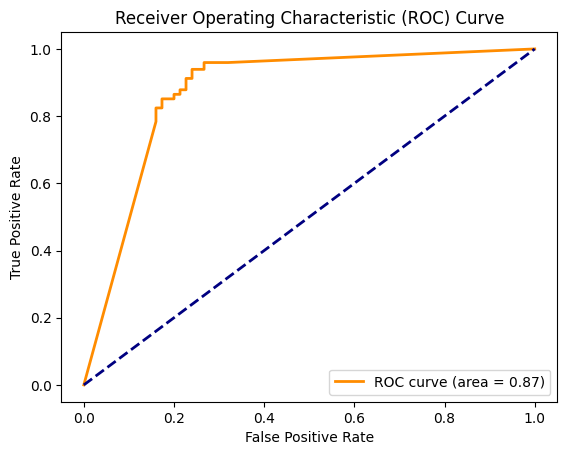

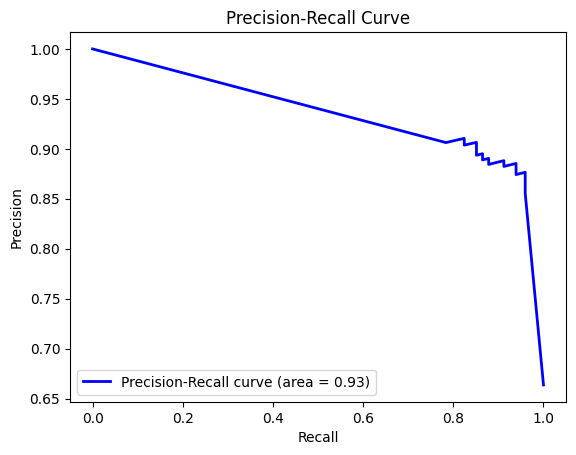

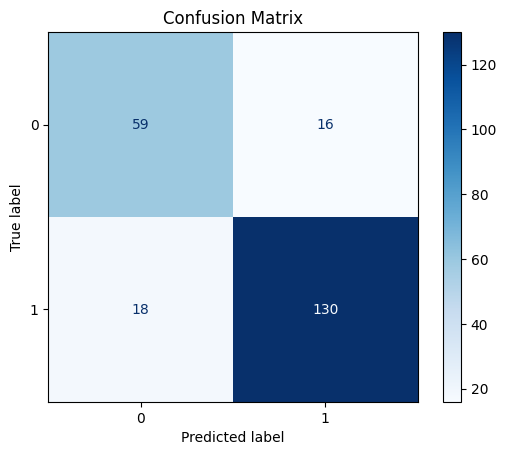

In [464]:
import matplotlib.pyplot as plt
import seaborn as sns


# After training, load the best model weights
if best_model_weights:
    model.load_state_dict(best_model_weights)
    torch.save(model.state_dict(), "best_model_weights.pth")
    print(f"Best model saved with Val Loss: {best_val_loss:.4f} and Val ROC-AUC: {best_roc_auc:.4f}")

    # Evaluate the best model on validation set
    model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch).squeeze()
            val_predictions.extend(y_pred.numpy())
            val_targets.extend(y_batch.numpy())

    threshold = 0.6
    # Compute final metrics
    val_accuracy = accuracy_score(val_targets, (np.array(val_predictions) >= threshold).astype(int))
    val_roc_auc = roc_auc_score(val_targets, val_predictions)
    val_auprc = average_precision_score(val_targets, val_predictions)

    print(f"Final Val Accuracy: {val_accuracy:.4f}")
    print(f"Final Val ROC-AUC: {val_roc_auc:.4f}")
    print(f"Final Val AUPRC: {val_auprc:.4f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(val_targets, val_predictions)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(val_targets, val_predictions)
    auc_pr = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall curve (area = {auc_pr:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

    # Confusion Matrix Plot
    cm = confusion_matrix(val_targets, (np.array(val_predictions) >= threshold).astype(int))
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [465]:
# Preprocess test data
test_features = test_features.reindex(columns=train_features.columns, fill_value=0)
X_test = preprocess_data(test_features, fit=False)
X_test_pca = pca.transform(X_test[:, :1425])
X_test = np.hstack((X_test_pca, X_test[:, 1425:]))
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Generate submission file
def generate_submission_file(model, X_test_tensor, file_name):
    model.eval()
    with torch.no_grad():
        test_probabilities = model(X_test_tensor).squeeze().numpy() # Make it 2D and numpy
    test_predictions = (test_probabilities > threshold).astype(int)
    submission = pd.DataFrame({
        'predicted_label': test_predictions,
        'prediction_score': test_probabilities
    })
    submission.to_csv(file_name, index=False)

output_file = "test_predictions_task2_58352.csv"
generate_submission_file(best_model, X_test_tensor, output_file)